<a href="https://colab.research.google.com/github/AchrafAsh/gnn-receptive-fields/blob/main/01_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TODO

- refactor to compute the k-hop neighborhoods just once!
- modify GCNConv to take the neighbor input features (instead of the hidden state) but the target node hidden state (as usual)
- track over-smoothing with **MAD** and **MADGap** over
- try to inverse the k-hop neighbors (start from remote and move down)

# Experimenting with our own Approach

## Setup environment

- load packages from google drive (to install once)
- configure working directory (to download datasets)



In [1]:
# setup colab environment
import os, sys
import os.path as osp
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)  # or append(nb_path)

Mounted at /content/mnt


In [2]:
%%capture
!wget https://raw.githubusercontent.com/AchrafAsh/gnn-receptive-fields/main/data.py
!wget https://raw.githubusercontent.com/AchrafAsh/gnn-receptive-fields/main/utils.py

In [ ]:
# import utility functions
from data import load_dataset
# from utils import mean_average_distance, mean_average_distance_gap

In [4]:
from torch_geometric.datasets import Planetoid, TUDataset, PPI, QM9, Amazon, Reddit2


def load_dataset(path, name, transform=None, params=None):
    if name == 'Cora':
        return Planetoid(path, 'Cora', transform=transform)
    elif name == 'CiteSeer':
        return Planetoid(path, 'CiteSeer', transform=transform)
    elif name == 'PubMed':
        return Planetoid(path, 'PubMed', transform=transform)
    elif name == 'PPI':
        return PPI(path, transform=transform)
    elif name == 'ENZYMES':
        return TUDataset(path, 'ENZYMES', transform=transform)
    elif name == 'QM9':
        return QM9(path, transform=transform)
    elif name == 'Amazon':
        if params['goods']:
            goods = params['goods']
        else:
            goods = 'Computers'
        return Amazon(path, name=goods, transform=transform)
    elif name == 'Reddit':
        return Reddit2(path, transform=transform)

In [5]:
path = osp.join(os.getcwd(), 'data')
cora_dataset = load_dataset(path, 'Cora')
G = cora_dataset[0] # only graph of the dataset

# MAD_cora = mean_average_distance(x=G.x)
# MADGap_cora = mean_average_distance_gap(x=G.x, adj_matrix=tg.utils.to_dense_adj(G.edge_index)[0])
# print(f'Initial MAD for Cora: {MAD_cora}')
# print(f'Initial MADGap for Cora: {MADGap_cora}')

Processing...
Done!


## The data (Cora): structure, processing


🎯 Filter edge_index to keep only the k-hop neighbors

In [6]:
G = cora_dataset[0] # Cora has only one graph
G.edge_index.shape  # [2, 10556] → 10_556 edges

torch.Size([2, 10556])

In [34]:
node_a, node_b = G.edge_index[:,0]
node_i, node_j = node_a, node_b
i = 0
while node_i != node_b and node_j != node_a and i < G.edge_index.size(1):
    node_i, node_j = G.edge_index[:, i]
    i += 1
if i != G.edge_index.size(1):
    print("found it!")

found it!


That means that `edge_index` has both `a → b` and `b → a` (this is important for later processing)

In [10]:
# edge_index is a sparse matrix of two rows, 
# each column is a pair of adjacent nodes 
# (not handy to find the neighbors of a given node)
i = 0
while i < 10:
    node_i, node_j = G.edge_index[:, i]
    if node_i != 0: break
    print(f"{node_i} → {node_j}")
    i += 1

0 → 633
0 → 1862
0 → 2582


In [193]:
import copy
import torch
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

from torch_geometric.utils import to_dense_adj, dense_to_sparse

In [132]:
def get_neighbors(edge_index: torch.tensor) -> dict:
    E = edge_index.size(1)
    neighbors = {}
    for i in range(E):
        node_i, node_j = edge_index[:, i]
        node_i, node_j = node_i.item(), node_j.item()
        try:
            neighbors[node_i] += [node_j]
        except:
            neighbors[node_i] = [node_j]
    return neighbors

In [215]:
def get_next_hop_neighbors(edge_index, direct_neighbors, neighborhood):
    """Returns the next hop of neighbors

    Args:
        edge_index (tensor): sparse adjacency matrix composed of edge indices
        direct_neighbors (dict): all the adjacent nodes
        neighborhood (dict): all the nodes in the (k-1)-hop neighborhood
    
    Returns:
        tensor: sparse matrix containing edge indices of the k-hop neighbors
        dict: direct neighbors
        dict: all the nodes in the k-hop neighborhood
    """
    neighborhood = copy.deepcopy(neighborhood)
    
    E = edge_index.size(1)
    new_edge_index = []
    for i in range(E):
        node_i, node_j = edge_index[:, i]
        node_i, node_j = node_i.item(), node_j.item()
        
        for node_k in neighbors[node_j]:
            if node_k == node_i or node_k in neighborhood[node_i]: continue
            new_edge_index.append([node_i, node_k])
            neighborhood[node_i] += [node_k]
    
    if len(new_edge_index) > 0:
        new_edge_index = torch.transpose(torch.tensor(new_edge_index, dtype=edge_index.dtype), 1, 0)
    
    return new_edge_index, neighborhood

In [138]:
def get_all_hops(edge_index, k=1):
    """Returns all the k-hop neighbors and neighborhoods (all steps)

    Args:
        edge_index (tensor): sparse adjacency matrix composed of edge indices
        k (int): hop of neighbors to keep (e.g. k=1 is the regular adjacency matrix)
    
    Returns:
        List[tensor]: list of k sparse matrices containing edge indices for each k-hop
        List[dict]: list of k dictionaries (neighborhoods)
    """
    direct_neighbors = get_neighbors(edge_index)
    neighborhood = copy.deepcopy(direct_neighbors)
    
    if k == 1:
        return [edge_index], [neighborhood]
    
    all_edge_index, all_neighborhoods = [edge_index], [neighborhood]

    for i in range(1, k+1):
        next_edge_index, neighborhood = get_next_hop_neighbors(edge_index=all_edge_index[i-1], 
                                                               direct_neighbors=direct_neighbors,
                                                               neighborhood=all_neighborhoods[i-1])
        all_edge_index += [next_edge_index]
        all_neighborhoods += [neighborhood]

    return all_edge_index, all_neighborhoods

### Visualize neighborhood expansion

The diameter of the Cora dataset is 20, so in theory, the maximum number of neighbors should decrease all the way down to zero for `k=20`.
Let's check:

In [209]:
nb_k_hop_neighbors = []
size_k_hop_neighborhood = []
k_grid = range(1, 20)

edge_index = G.edge_index
direct_neighbors = get_neighbors(G.edge_index)
neighborhood = copy.deepcopy(direct_neighbors)

# count neighbors
max_neighbors = len(max(direct_neighbors.values(), key=len))
min_neighbors = len(min(direct_neighbors.values(), key=len))
nb_k_hop_neighbors.append([min_neighbors, max_neighbors])

# count neighborhood
max_neighborhood = len(max(neighborhood.values(), key=len))
min_neighborhood = len(min(neighborhood.values(), key=len))
size_k_hop_neighborhood.append([min_neighborhood, max_neighborhood])

for k in k_grid:
    edge_index, neighborhood = get_next_hop_neighbors(edge_index=edge_index,
                                                      neighbors=direct_neighbors,
                                                      neighborhood=neighborhood)
    k_hop_neighbors = get_neighbors(edge_index)
    
    # count neighbors
    max_neighbors = len(max(k_hop_neighbors.values(), key=len))
    min_neighbors = len(min(k_hop_neighbors.values(), key=len))
    nb_k_hop_neighbors.append([min_neighbors, max_neighbors])

    # count neighborhood
    max_neighborhood = len(max(neighborhood.values(), key=len))
    min_neighborhood = len(min(neighborhood.values(), key=len))
    size_k_hop_neighborhood.append([min_neighborhood, max_neighborhood])

100%|██████████| 2/2 [00:00<00:00, 2181.13it/s]


IndexError: ignored

[Text(0.5, 1.0, 'Neighborhood expansion on Cora')]

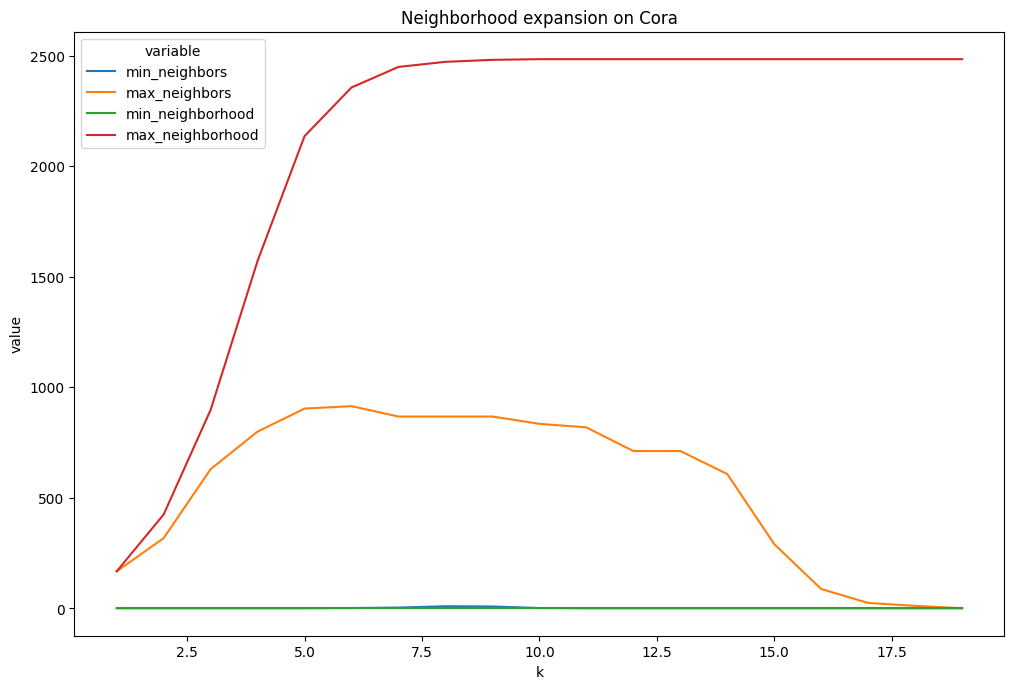

In [211]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# credit to: https://stackoverflow.com/a/55579762/11805354
data = pd.DataFrame({
    'k': range(1, 20),
    'min_neighbors': torch.tensor(nb_k_hop_neighbors)[:, 0],
    'max_neighbors': torch.tensor(nb_k_hop_neighbors)[:, 1],
    'min_neighborhood': torch.tensor(size_k_hop_neighborhood)[:, 0],
    'max_neighborhood': torch.tensor(size_k_hop_neighborhood)[:, 1],
})
sn.lineplot(x='k', y='value', hue='variable', data=pd.melt(data, ['k'])).set(title="Neighborhood expansion on Cora")

In [212]:
data

,k,min_neighbors,max_neighbors,min_neighborhood,max_neighborhood
0,1,1,168,1,168
1,2,1,318,1,425
2,3,1,630,1,898
3,4,1,800,1,1572
4,5,1,904,1,2136
5,6,2,915,1,2356
6,7,4,868,1,2449
7,8,10,868,1,2472
8,9,9,868,1,2481
9,10,2,835,1,2484


Explanation:
- the min_neighbors can be bigger than min_neighborhood if two adjacent nodes are isolated, they will then be disregarded for the next hops, and thus not be considered for the min_neighborhood 💡

Result: the max_neighbors reach zero for the 20th hop which is what we expected ✅

## The model: our approach

In [271]:
import math
import random

import torch_geometric
import torch.nn.functional as F

from torch_geometric.nn import GCNConv

In [213]:
def xavier(tensor):
    """Initialize weight matrix with Xavier distribution

    Args:
        tensor (tensor): weigh matrix
    Return:
        tensor - weight matrix initialized
    """
    if tensor is not None:
        stdv = math.sqrt(6.0 / (tensor.size(-2) + tensor.size(-2)))
        tensor.data.uniform_(-stdv, stdv)

def zeros(tensor):
    """Initialize bias vector with all zeros

    Args:
        tensor (tensor): bias vector
    
    Return
        tensor - bias vector initialized with zeros
    """
    if tensor is not None:
        tensor.data.fill_(0)

In [250]:
class KHopNet(torch.nn.Module):
    def __init__(self, num_features:int, num_classes:int, K:int, dropout:float=0.3):
        super(KHopNet, self).__init__()
        self.num_features = num_features
        self.num_classes = num_classes
        self.K = K
        self.conv_layers = self.create_conv_layers(K, dropout)
    
    def create_conv_layers(K:int, dropout:float):
        layers = []
        in_channels = self.num_features
        for k in range(K):
            if k != K-1:
                layers += [
                    GCNConv(in_channels=in_channels, out_channels=in_channels),
                    torch.nn.ReLU(),
                    torch.nn.Dropout(p=dropout),
                    ExpandNeighbors(),
                ]
            else:
                layers += [
                    GCNConv(in_channels=in_channels, out_channels=self.num_classes)
                ]
    
    def reset_parameters(self):
        for k in range(self.K):
            self.layers[k].reset_parameters()
    
    def forward(self, x, edge_index, direct_neighbors, dropout=.3):
        neighborhood = copy.deepcopy(direct_neighbors)
        x = F.relu(self.layers[0](x, edge_index))
        for k in range(1, self.K):    
            edge_index, _, neighborhood = get_next_hop_neighbors(edge_index, direct_neighbors, neighborhood)
            x = F.dropout(x, p=dropout, training=self.training)
            x = F.relu(self.layers[k](x, edge_index))
        
        return F.log_softmax(x, dim=1)

In [ ]:
def train(model: torch.nn.Module, optimizer: torch.optim.Optimizer,
          data: type(G)):
    """Performs one training sep
    """
    model.train()
    optimizer.zero_grad()

    direct_neighbors = get_neighbors(data.edge_index)
    neighborhood = copy.deepcopy(direct_neighbors)
    out = model(data.x, data.edge_index, direct_neighbors, neighborhood)
    
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
def evaluate(model: torch.nn.Module, data: type(G)):
    model.eval()

    with torch.no_grad():
        direct_neighbors = get_neighbors(data.edge_index)
        neighborhood = copy.deepcopy(direct_neighbors)
        logits = model(data.x, data.edge_index, direct_neighbors, neighborhood)
    
    outs = {}
    for key in ['train', 'val', 'test']:
        mask = data[f'{key}_mask']
        loss = F.nll_loss(logits[mask], data.y[mask]).item()
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()

        outs[f'{key}_loss'] = loss
        outs[f'{key}_acc'] = acc
    return outs

In [304]:
def run(data: type(G), model: torch.nn.Module, runs: int, epochs: int, lr: float, weight_decay: float, early_stopping: int = 0):
    val_losses, accs, durations = [], [], []
    for _ in range(runs):
        data = data.to(device)
        model.to(device).reset_parameters()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        
        t_start = time.perf_counter()

        best_val_loss = float('inf')
        test_acc = 0
        val_loss_history = []

        for epoch in range(1, epochs+1):
            train_loss = train(model, optimizer, data)
            # eval_info = evaluate(model, data)
            # eval_info['epoch'] = epoch
        
            # if eval_info['val_loss'] < best_val_loss:
            #     best_val_loss = eval_info['val_loss']
            #     test_acc = eval_info['test_acc']
            
            # val_loss_history.append(eval_info['val_loss'])
            # if early_stopping > 0 and epoch > epochs // 2:
            #     tmp = torch.tensor(val_loss_history[-(early_stopping + 1):-1])
            #     if eval_info['val_loss'] > tmp.mean().item():
            #         break
            
            if epoch % 10 == 0:
                print(f"Epoch: [{epoch} / {epochs}] | Loss: {train_loss}")

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_end = time.perf_counter()

        val_losses.append(best_val_loss)
        accs.append(test_acc)
        durations.append(t_end - t_start)

    loss, acc, duration = torch.tensor(val_losses), torch.tensor(accs), torch.tensor(durations)

    print(f"Val Loss: {loss.mean().item():.4f}, Test Accuracy: {acc.mean().item():.3f} ± {acc.std().item():.3f}, Duration: {duration.mean().item():.3f}"

SyntaxError: ignored

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = KHopNet(num_features=cora_dataset.num_features, num_classes=cora_dataset.num_classes, K=3)

In [265]:
# count model parameters
def count_parameters(model: torch.nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [303]:
# model should be as follows:
dropout=0.5
model = torch_geometric.nn.Sequential("x, edge_index, direct_neighbors, neighborhood",[
    # first hop
    (GCNConv(in_channels=cora_dataset.num_features, out_channels=64), "x, edge_index -> x"),
    (torch.nn.ReLU(), "x -> x"),
    (torch.nn.Dropout(p=dropout), "x -> x"),
    (get_next_hop_neighbors, "edge_index, direct_neighbors, neighborhood -> edge_index, neighborhood"),

    # second hop
    (GCNConv(in_channels=64, out_channels=64), "x, edge_index -> x"),
    (torch.nn.ReLU(), "x -> x"),
    (torch.nn.Dropout(p=dropout), "x -> x"),
    (get_next_hop_neighbors, "edge_index, direct_neighbors, neighborhood -> edge_index, neighborhood"),

    # third hop
    (GCNConv(in_channels=64, out_channels=64), "x, edge_index -> x"),
    (torch.nn.ReLU(), "x -> x"),
    (torch.nn.Dropout(p=dropout), "x -> x"),
    (get_next_hop_neighbors, "edge_index, direct_neighbors, neighborhood -> edge_index, neighborhood"),

    # # fourth hop
    # (GCNConv(in_channels=64, out_channels=64), "x, edge_index -> x"),
    # (torch.nn.ReLU(), "x -> x"),
    # (torch.nn.Dropout(p=dropout), "x -> x"),
    # (get_next_hop_neighbors, "edge_index, direct_neighbors, neighborhood -> edge_index, neighborhood"),

    # # fifth hop
    # (GCNConv(in_channels=64, out_channels=64), "x, edge_index -> x"),
    # (torch.nn.ReLU(), "x -> x"),
    # (torch.nn.Dropout(p=dropout), "x -> x"),
    # (get_next_hop_neighbors, "edge_index, direct_neighbors, neighborhood -> edge_index, neighborhood"),
    
    # final layer
    (GCNConv(in_channels=64, out_channels=cora_dataset.num_classes), "x, edge_index -> x"),

    (torch.nn.LogSoftmax(dim=1), "x -> x")
])

model.reset_parameters()

In [298]:
count_parameters(model)

100551

In [291]:
# without K-hop
run(data=G, model=model,
    runs=1, epochs=2,
    lr=0.01, weight_decay=0.1,
    early_stopping=10)

Val Loss: -0.1877, Test Accuracy: 0.138 ± nan, Duration: 0.454


In [293]:
# with K-hop
run(data=G, model=model,
    runs=1, epochs=2,
    lr=0.01, weight_decay=0.1,
    early_stopping=10)

100%|██████████| 10556/10556 [00:00<00:00, 20851.72it/s]

Val Loss: -0.1944, Test Accuracy: 0.192 ± nan, Duration: 2.305


In [302]:
# with 6-hop layers
run(data=G, model=model,
    runs=1, epochs=100,
    lr=0.01, weight_decay=0.0005,
    early_stopping=10)

100%|██████████| 247250/247250 [00:10<00:00, 22862.93it/s]


Val Loss: -0.6132, Test Accuracy: 0.615 ± nan, Duration: 1573.341
